<a href="https://colab.research.google.com/github/jaseela2123/Underwater-Image-Enhancement-Using-Deep-learning/blob/main/Underwater_image_enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/S6 project/datasets/UFO-120"
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os 
os.chdir(DATASET_PATH)

Mounted at /content/drive


In [ ]:
def image_ld(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [ ]:
def img_path(orig_image_path, hazy_image_path):
    
    training_image = []
    validation_image = []
    
    original_image = glob.glob(orig_image_path + '/*.jpg')
    n = len(original_image)
    random.shuffle(original_image)
    train_keys = original_image[:int(0.9*n)]        
    val_keys = original_image[int(0.9*n):]
    
    split_dictionary = {}
    for key in train_keys:
        split_dictionary[key] = 'train'
    for key in val_keys:
        split_dictionary[key] = 'val'
        
    hazy_image = glob.glob(hazy_image_path + '/*.jpg')
    for image in hazy_image:
        image_name = image.split('/')[-1]
        orig_path = orig_image_path + '/' + image_name
        if (split_dictionary[orig_path] == 'train'):
            training_image.append([image, orig_path])
        else:
            validation_image.append([image, orig_path])
            
    return training_image, validation_image

In [ ]:
def train_val_loader(train_data, val_data, batch_size):
    
    train_data_origimg = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: image_ld(x))
    train_data_hazeimg = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: image_ld(x))
    train = tf.data.Dataset.zip((train_data_hazeimg, train_data_origimg)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_origimg = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: image_ld(x))
    val_data_hazeimg = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: image_ld(x))
    val = tf.data.Dataset.zip((val_data_hazeimg, val_data_origimg)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [ ]:
def display(model, hazy_image, original_image):
    
    dehazed_image = model(hazy_image, training = True)
    plt.figure(figsize = (15,15))
    
    display_image_list = [hazy_image[0], original_image[0], dehazed_image[0]]
    title = ['Input Image', 'Ground Truth', 'Enhanced Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_image_list[i])
        plt.axis('off')
        
    plt.show()

In [ ]:
def generic_model():
    
    inputs = tf.keras.Input(shape = [412, 548, 3])    
    
                                    
        
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                  bias_initializer = bias_init, kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                  bias_initializer = bias_init, kernel_regularizer = regularizer)(conv)
    
                                       
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv)
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv_up)
                                    
                                   
    conv1_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                   bias_initializer = bias_init, kernel_regularizer = regularizer)(conv_up)
    conv1_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv1_1)
    conv1_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                   bias_initializer = bias_init, kernel_regularizer = regularizer)(conv1_2)
    conc1 = tf.add(conv1_3, conv1_1)
    conv1 = tf.keras.activations.relu(conc1)

    conv2_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv1)
    conv2_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv2_1)
    conv2_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv2_2)
    conc2 = tf.add(conv2_3, conv2_1)
    conv2 = tf.keras.activations.relu(conc2)

    conv3_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv2)
    conv3_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv3_1)
    conv3_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv3_2)
    conv3_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv3_3)
    conv3_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv3_4)
    conc3 = tf.add(conv3_5, conv3_1)
    conv3 = tf.keras.activations.relu(conc3)

    conv4_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv3)
    conv4_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)

    conv5_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv4)
    conv5_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv5_1)
    conv5_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv5_2)
    conv5_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv5_3)
    conv5_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv5_4)
    conc5 = tf.add(conv5_5, conv5_1)
    conv5 = tf.keras.activations.relu(conc5)

    conv6_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv5)
    conv6_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv6_1)
    conv6_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv6_2)
    conv6_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv6_3)
    conv6_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = bias_init, kernel_regularizer = regularizer)(conv6_4)
    conc6 = tf.add(conv6_5, conv6_1)
    conv6 = tf.keras.activations.relu(conc6)

                                            
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv5)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                  bias_initializer = bias_init, kernel_regularizer = regularizer)(deconv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = bias_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    gman_net_output = tf.keras.activations.relu(conc)
    
     # Parallel Network 
    
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                 kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = kernal_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                           activation = 'relu', kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                 kernel_regularizer = regularizer)(deconv)
    
    conc = tf.add(conv, inputs)
    parallel_output = tf.keras.activations.relu(conc)
    
    output = tf.add(gman_net_output, parallel_output)
    mod = Model(inputs = inputs, outputs = output)
    print(mod.summary())
    
    return Model(inputs = inputs, outputs = output)



In [ ]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [ ]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(np.float32(img1), -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(np.float32(img2), -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(np.float32(img1)**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(np.float32(img2)**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(np.float32(img1) * np.float32(img2), -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
epochs = 5
batch_size = 8
kernal_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
bias_init = tf.constant_initializer()

training_image, validation_image = img_path(orig_image_path = os.path.join(DATASET_PATH,"train_val","hr" ), hazy_image_path = os.path.join(DATASET_PATH,"train_val","lrd"))
train, val = train_val_loader(training_image, validation_image, batch_size)

optimizer = Adam(learning_rate = 1e-4)
gnet = generic_model()
tloss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
vloss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 412, 548, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_78 (Conv2D)             (None, 412, 548, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_79 (Conv2D)             (None, 412, 548, 64  36928       ['conv2d_78[0][0]']              
                                )                                                           

In [ ]:
def train_model(epochs, train, val, gnet, tloss_tracker, vloss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        for step, (train_batch_hazeimg, train_batch_origimg) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = gnet(train_batch_hazeimg, training = True)
                loss = mean_squared_error(train_batch_origimg, train_logits)

            grads = tape.gradient(loss, gnet.trainable_weights)
            optimizer.apply_gradients(zip(grads, gnet.trainable_weights))

            tloss_tracker.update_state(train_batch_origimg, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (tloss_tracker.result()), end='')
        

        # validation loop
        for step, (val_batch_hazeimg, val_batch_origimg) in enumerate(val):
            val_logits = gnet(val_batch_hazeimg, training = False)
            vloss_tracker.update_state(val_batch_origimg, val_logits)
            
            if step % 32 ==0:
                display(gnet, val_batch_hazeimg, val_batch_origimg)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (vloss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        gnet.save('trained_model')          
        tloss_tracker.reset_states()
        vloss_tracker.reset_states()


Start of epoch 0 [===]  -  Training Loss: 0.0466

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


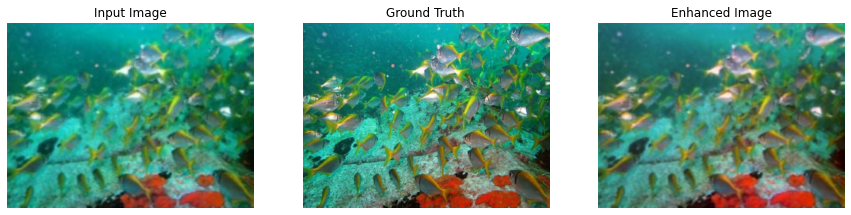

  -  Validation Loss: 0.0053  -   Time taken: 348.70s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 1 [===]  -  Training Loss: 0.0050

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


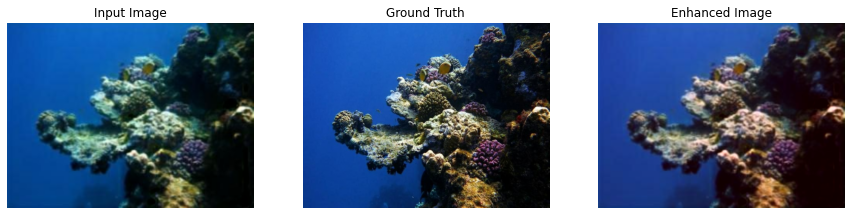

  -  Validation Loss: 0.0052  -   Time taken: 345.70s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 2 [===]  -  Training Loss: 0.0048

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


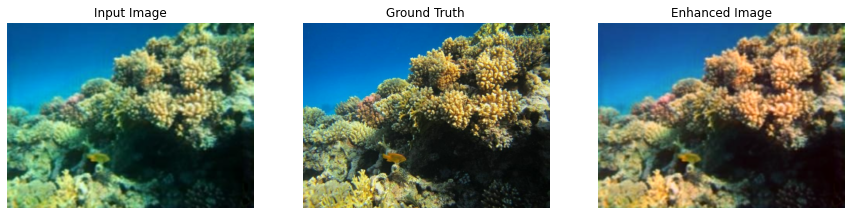

  -  Validation Loss: 0.0049  -   Time taken: 345.68s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 3 [===]  -  Training Loss: 0.0045

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


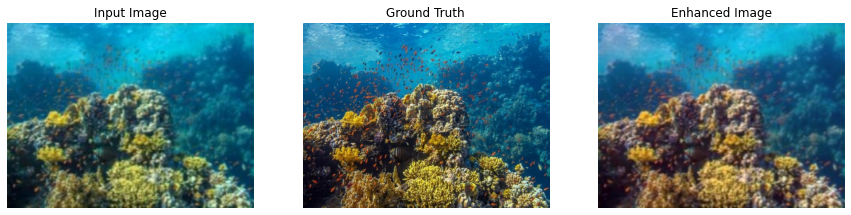

  -  Validation Loss: 0.0046  -   Time taken: 345.85s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 4 [===]  -  Training Loss: 0.0044

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


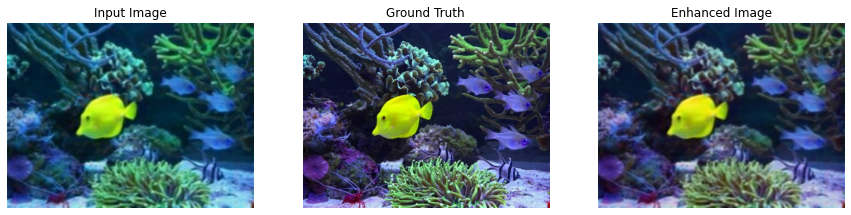

  -  Validation Loss: 0.0047  -   Time taken: 345.73s
INFO:tensorflow:Assets written to: trained_model/assets
CPU times: user 8min 54s, sys: 23.9 s, total: 9min 18s
Wall time: 29min 18s


In [ ]:
%%time
train_model(epochs, train, val, gnet, tloss_tracker, vloss_tracker, optimizer)

In [ ]:
def evaluate_fn(gnet, test_img_path):
    
    test_images = glob.glob(test_img_path + '/*.jpg')
    random.shuffle(test_images)
    psnr_imgs = []
    ssim_imgs = []
    
    for img in test_images:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        if img.shape[1] > img.shape[0]:
            img = tf.image.resize(img, size = (412, 548), antialias = True)
        if img.shape[1] < img.shape[0]:
            img = tf.image.resize(img, size = (412, 548), antialias = True)
        
        img = img / 255.0
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D
        
        dehazed = gnet(img, training = False)
        plt.figure(figsize = (80, 80))
        
        display_img = [img[0], dehazed[0]]       
        title = ['Input Image', 'Enhanced Image']
        psnr_imgs.append(calculate_psnr(img[0], dehazed[0]))
        
        ssim_imgs.append(calculate_ssim(img[0], dehazed[0]))

        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.title(title[i], fontsize = 65, y = 1.045)
            plt.imshow(display_img[i])
            plt.axis('off')
        
        plt.show()

    print("psnr values: ", psnr_imgs)
    print("ssim values: ", ssim_imgs)

In [ ]:
test_net = tf.keras.models.load_model('trained_model', compile = False)
evaluate_fn(test_net, '/content/drive/MyDrive/S6 project/datasets/UFO-120/TEST/lrd')